In [1]:
import os
os.sys.path.append('../lib/')
import numpy as np
import pandas as pd
import evaluate
import matplotlib.pyplot as plt

# load test predictions and labels
holdout_analytes = ['Hb', 'Ca', 'FT4', 'AST', 'LACT', 'GGT', 'TSH', 'IgE', 'CRP', 'LDH']
# holdout_analytes = ['Hb', 'AST', 'LACT', 'TSH']

files_test = []
p_test = []
y_test = []
model_path = './models_nodrop_2/'
for i in holdout_analytes:
    files_test.append(np.load(model_path+'model_'+i+'/data/files_test.npy'))
    p_test.append(np.load(model_path+'model_'+i+'/model_test_p_scaled.npy'))
    y_test.append(np.load(model_path+'model_'+i+'/model_test_y_scaled.npy'))
files_test = np.hstack(files_test)
p_test = np.vstack(p_test)
y_test = np.vstack(y_test)

ans_test = np.array([i.split('/')[-2] for i in files_test])


Hb      288
Ca      288
FT4     288
AST     288
LACT    288
GGT     288
TSH     288
IgE     288
CRP     288
LDH     288
Name: an, dtype: int64

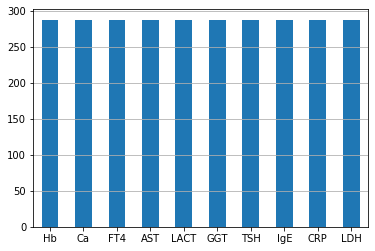

In [2]:
ans_test = np.array([i.split('/')[-2] for i in files_test])
pd.DataFrame({'an':ans_test})['an'].value_counts().plot.bar(rot=0).grid(axis='y')
plt.gcf().set_facecolor('white')
pd.DataFrame({'an':ans_test})['an'].value_counts()


## Example predictions per analyte

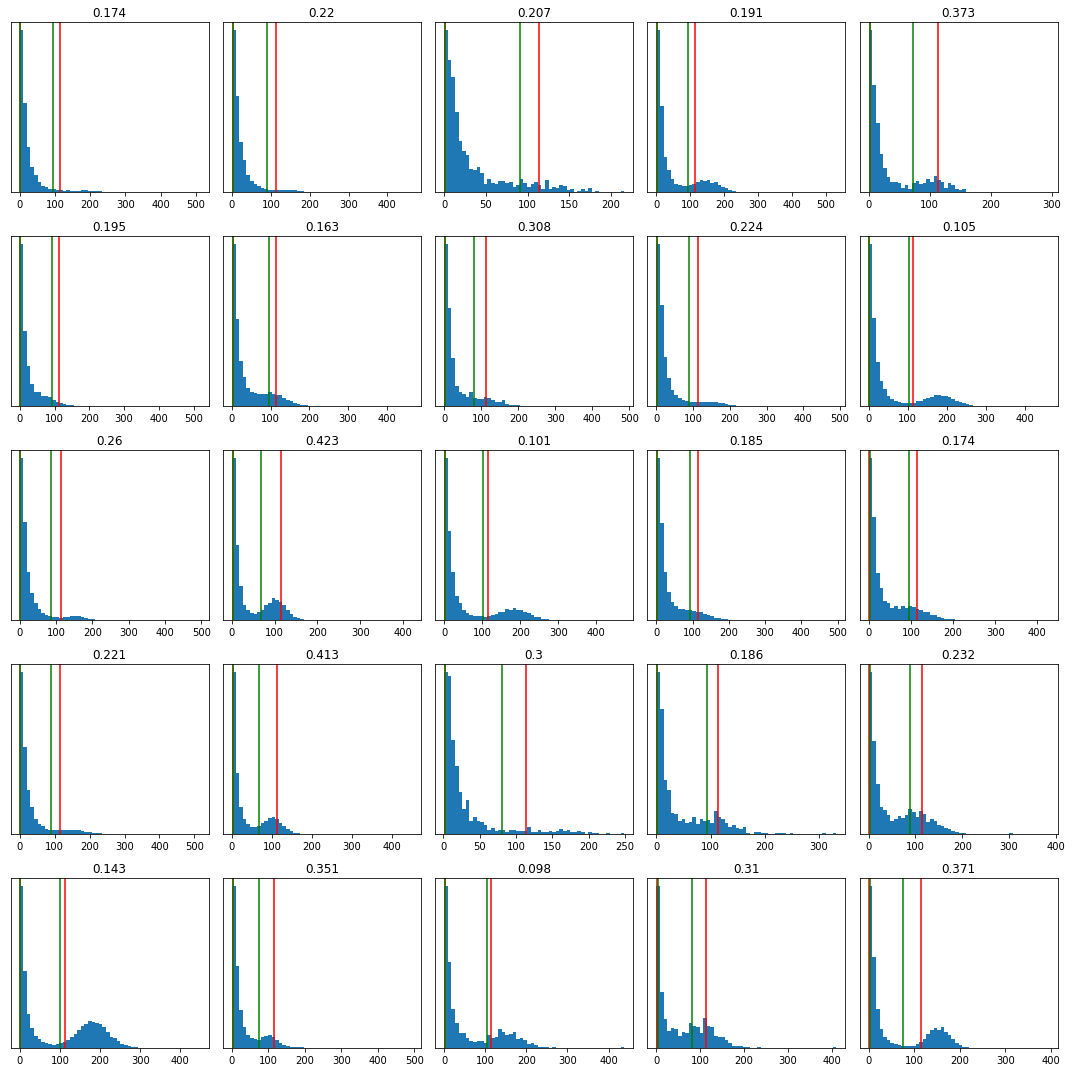

In [3]:
nr = 5
plt.figure(figsize=(15,15))
sample = np.random.choice(range(y_test.shape[0]), nr**2)
sample = np.where(ans_test=='IgE')[0]
for c,i in enumerate(sample[:nr**2]):
    plt.subplot(nr, nr, c+1)
    data = pd.read_csv(files_test[i], header=None).values
    data = data[(data>=np.quantile(data,0.001)) & (data<=np.quantile(data,0.999))]
    y = y_test[i]
    p = p_test[i] 
    
#     # optional
#     data = evaluate.zscore_transform(data, y_test[i][2], y_test[i][3], y_test[i][4], y_test[i][5])
#     y = evaluate.zscore_transform(y_test[i], y_test[i][2], y_test[i][3], y_test[i][4], y_test[i][5])
#     p = evaluate.zscore_transform(p_test[i], y_test[i][2], y_test[i][3], y_test[i][4], y_test[i][5])   
    
    normy, nrmp = evaluate.normp(y, p)
    
    plt.hist(data, 50, density=True);
    if not ans_test[i]=='CRP':
        plt.axvline(y[0], c='r')
        plt.axvline(p[0], c='g')
    plt.axvline(y[1], c='r')
    plt.axvline(p[1], c='g')
    plt.gca().set_yticks([])
    plt.title(round(np.mean(np.abs(normy-nrmp)), 3))
    
plt.gcf().patch.set_facecolor('white')
plt.gcf().tight_layout()


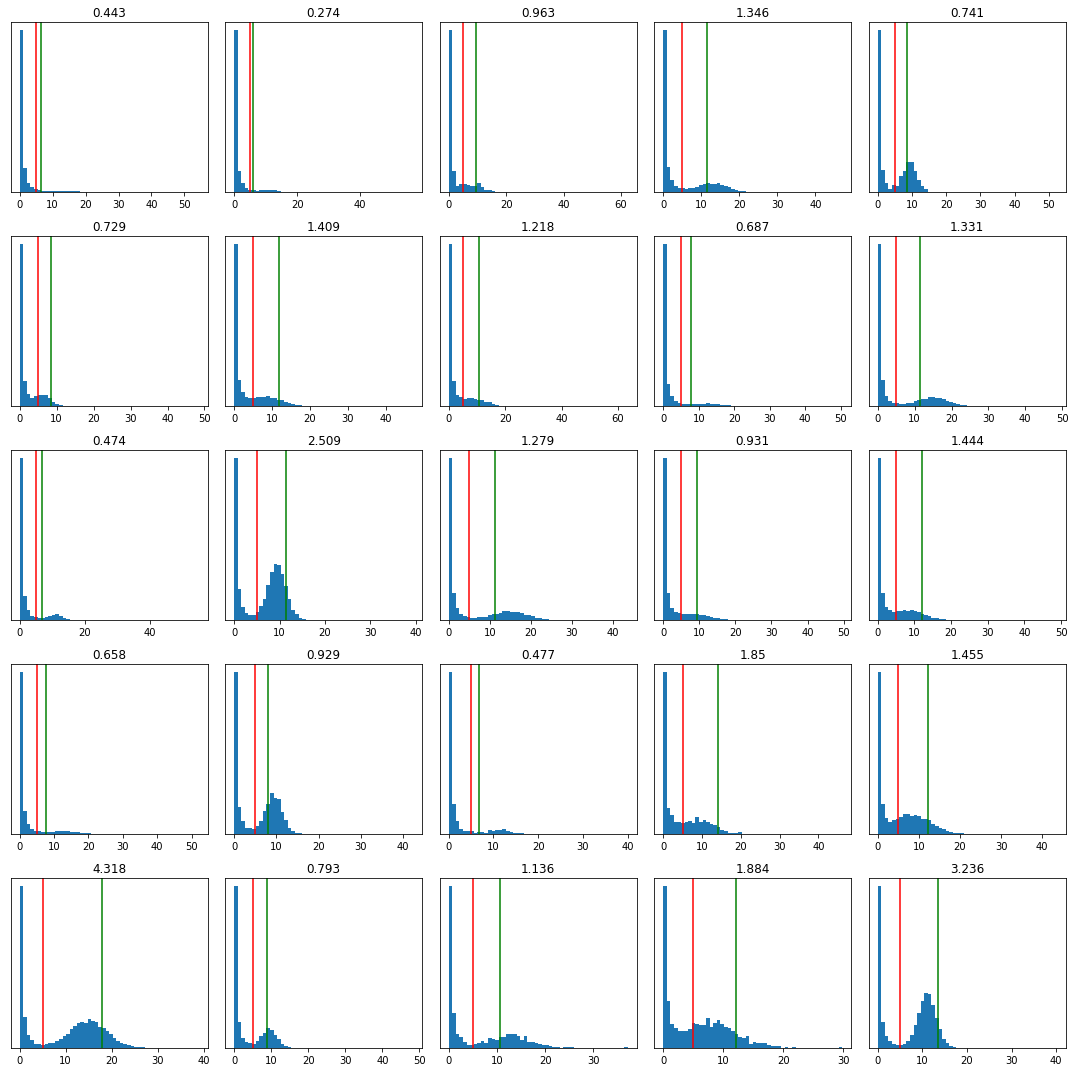

In [4]:
nr = 5
plt.figure(figsize=(15,15))
sample = np.random.choice(range(y_test.shape[0]), nr**2)
sample = np.where(ans_test=='CRP')[0]
for c,i in enumerate(sample[:nr**2]):
    plt.subplot(nr, nr, c+1)
    data = pd.read_csv(files_test[i], header=None).values
    data = data[(data>=np.quantile(data,0.001)) & (data<=np.quantile(data,0.999))]
    y = y_test[i]
    p = p_test[i] 
    
#     # optional
#     data = evaluate.zscore_transform(data, y_test[i][2], y_test[i][3], y_test[i][4], y_test[i][5])
#     y = evaluate.zscore_transform(y_test[i], y_test[i][2], y_test[i][3], y_test[i][4], y_test[i][5])
#     p = evaluate.zscore_transform(p_test[i], y_test[i][2], y_test[i][3], y_test[i][4], y_test[i][5])   
    
    normy, nrmp = evaluate.normp(y, p)
    
    plt.hist(data, 50, density=True);
    if not ans_test[i]=='CRP':
        plt.axvline(y[0], c='r')
        plt.axvline(p[0], c='g')
    plt.axvline(y[1], c='r')
    plt.axvline(p[1], c='g')
    plt.gca().set_yticks([])
    plt.title(round(np.mean(np.abs(normy-nrmp)), 3))
    
plt.gcf().patch.set_facecolor('white')
plt.gcf().tight_layout()


## z-score deviation per group

In [5]:
# error by analyte
sorted_analytes_skew = ['Hb', 'Ca', 'FT4', 'AST', 'LACT', 'GGT', 'TSH', 'IgE', 'CRP', 'LDH']
analytes = np.array([i.split('_')[-3] for i in files_test])
zscore_devs = []
norm_errors = []
for i in sorted_analytes_skew:
    idx = np.where([j in i for j in analytes])[0]
    tmpzs = []
    tmpne = []
    for j in idx:
        if 'CRP' in files_test[j]:
            xt = evaluate.zscore_transform(p_test[j][1], y_test[j][2], y_test[j][3], y_test[j][4], y_test[j][5])
            yt = evaluate.zscore_transform(y_test[j][1], y_test[j][2], y_test[j][3], y_test[j][4], y_test[j][5])
            tmpzs.append(np.abs(xt-yt))
            
            normy, nrmp = evaluate.normp(y_test[j], p_test[j])
            tmpne.append(np.abs(normy[1] - nrmp[1]))
            
        else:
            if p_test[j,0]-y_test[j,5]<=0:
                tmpzs.append(np.nan)
            else:
                tmpzs.append(evaluate.zscore_deviation(y_test[j], p_test[j]))
                
            normy, nrmp = evaluate.normp(y_test[j], p_test[j])
            tmpne.append(np.mean(np.abs(normy - nrmp)))

    zscore_devs.append(np.nanmean(tmpzs))
    norm_errors.append(np.nanmean(tmpne))
    
    print(i, ' - ', round(len(np.where(np.isnan(tmpzs))[0])/len(tmpzs), 3), " z-score dev. nan's")
    print(i, ' - ', round(len(np.where(np.isnan(tmpne))[0])/len(tmpne), 3), " norm. error nan's")
    
df = pd.DataFrame({'analyte': sorted_analytes_skew,
                   'zscore_dev': zscore_devs,
                   'norm_errors': norm_errors})
df


Hb  -  0.0  z-score dev. nan's
Hb  -  0.0  norm. error nan's
Ca  -  0.0  z-score dev. nan's
Ca  -  0.0  norm. error nan's
FT4  -  0.0  z-score dev. nan's
FT4  -  0.0  norm. error nan's
AST  -  0.0  z-score dev. nan's
AST  -  0.0  norm. error nan's
LACT  -  0.0  z-score dev. nan's
LACT  -  0.0  norm. error nan's
GGT  -  0.0  z-score dev. nan's
GGT  -  0.0  norm. error nan's
TSH  -  0.014  z-score dev. nan's
TSH  -  0.0  norm. error nan's
IgE  -  0.003  z-score dev. nan's
IgE  -  0.0  norm. error nan's
CRP  -  0.0  z-score dev. nan's
CRP  -  0.0  norm. error nan's
LDH  -  0.0  z-score dev. nan's
LDH  -  0.0  norm. error nan's


,analyte,zscore_dev,norm_errors
0,Hb,0.229403,0.117045
1,Ca,0.278662,0.142356
2,FT4,0.149397,0.073578
3,AST,0.168296,0.084816
4,LACT,0.165110,0.098424
5,GGT,0.188771,0.090507
6,TSH,0.273662,0.211681
7,IgE,0.345066,0.234135
8,CRP,0.316764,1.558810
9,LDH,0.191637,0.082079


In [6]:
print('Average z-score deviation:\t', df.zscore_dev.mean())
print('Average norm. error:\t\t', df.norm_errors.mean())


Average z-score deviation:	 0.23067688354319263
Average norm. error:		 0.269343024249478


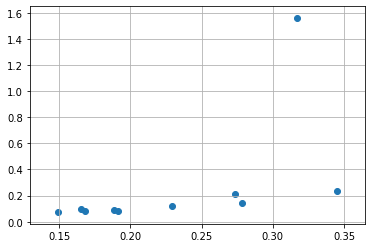

In [7]:
plt.scatter(df.zscore_dev, df.norm_errors)
plt.grid();
plt.gcf().set_facecolor('white');


In [8]:
# error by skew group
sorted_analytes_skew = [['Hb', 'Ca', 'FT4'], ['AST', 'LACT', 'GGT'], ['TSH', 'IgE', 'CRP'], ['LDH']]
analytes = np.array([i.split('_')[-3] for i in files_test])
zscore_devs = []
norm_errors = []
for i in sorted_analytes_skew:
    idx = np.where([j in i for j in analytes])[0]
    tmpzs = []
    tmpne = []
    for j in idx:
        if 'CRP' in files_test[j]:
            xt = evaluate.zscore_transform(p_test[j][1], y_test[j][2], y_test[j][3], y_test[j][4], y_test[j][5])
            yt = evaluate.zscore_transform(y_test[j][1], y_test[j][2], y_test[j][3], y_test[j][4], y_test[j][5])
            tmpzs.append(np.mean(np.abs(xt-yt)))
            
            normy, nrmp = evaluate.normp(y_test[j][:2], p_test[j])
            tmpne.append(np.abs(normy[1] - nrmp[1]))
            
        else:
            if p_test[j,0]-y_test[j,5]<=0:
                tmpzs.append(np.nan)
            else:
                tmpzs.append(evaluate.zscore_deviation(y_test[j], p_test[j]))
                
            normy, nrmp = evaluate.normp(y_test[j][:2], p_test[j])
            tmpne.append(np.mean(np.abs(normy - nrmp)))

    zscore_devs.append(np.nanmean(tmpzs))
    norm_errors.append(np.nanmean(tmpne))
    
    print(i, ' - ', round(len(np.where(np.isnan(tmpzs))[0])/len(tmpzs), 3), " z-score dev. nan's")
    print(i, ' - ', round(len(np.where(np.isnan(tmpne))[0])/len(tmpne), 3), " norm. error nan's")
    
df = pd.DataFrame({'group': ['normal', 'skewed', 'heavily_skewed', 'skewed_and_shifted'],
                   'zscore_dev': zscore_devs,
                   'norm_errors': norm_errors})
df


['Hb', 'Ca', 'FT4']  -  0.0  z-score dev. nan's
['Hb', 'Ca', 'FT4']  -  0.0  norm. error nan's
['AST', 'LACT', 'GGT']  -  0.0  z-score dev. nan's
['AST', 'LACT', 'GGT']  -  0.0  norm. error nan's
['TSH', 'IgE', 'CRP']  -  0.006  z-score dev. nan's
['TSH', 'IgE', 'CRP']  -  0.0  norm. error nan's
['LDH']  -  0.0  z-score dev. nan's
['LDH']  -  0.0  norm. error nan's


,group,zscore_dev,norm_errors
0,normal,0.219154,0.110993
1,skewed,0.174059,0.091249
2,heavily_skewed,0.311970,0.668208
3,skewed_and_shifted,0.191637,0.082079


## Calculate proposed normalized error

In [9]:
# proposed standardized error
errors = []
for i in range(p_test.shape[0]):
    normy, nrmp = evaluate.normp(y_test[i][:2], p_test[i])
    errors.append(np.mean(np.abs(normy - nrmp)))


## Error by pathological fraction

In [10]:
path = '/home/ubuntu/workspace-dev/reference_intervals/main/dataprep/data/RIbench/'
test_set_meta = pd.read_csv(path+'BMTestSets_meta.csv', index_col=0)

# error by pathological fraction
# get path fraction from metadata
def get_path_fraction(file):
    fileid = int(file.split('/')[-1].split('_')[0])
    target = test_set_meta[test_set_meta.Index==fileid].fractionPathol.values[0]
    return target

path_frac_test = []
for i in files_test:
    path_frac_test.append(get_path_fraction(i))
path_frac_test = np.array(path_frac_test)
errors = np.array(errors)


In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats


In [12]:
# pearson correlation between error and path frac
scipy.stats.pearsonr(path_frac_test, errors)


(0.2948097917039291, 7.557365596570684e-59)

In [13]:
# plt.scatter(path_frac_test, errors, alpha=0.1);
# plt.gcf().set_facecolor('white');


[]

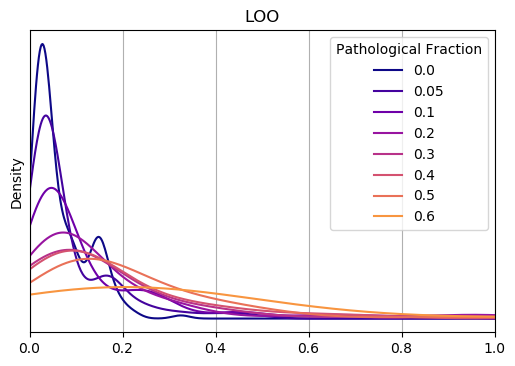

In [14]:
colormap = cm.get_cmap('plasma')  # Replace 'viridis' with the desired colormap
colors = colormap(np.linspace(0, 0.75, len(set(path_frac_test))))
# alphas = np.linspace(0.1, 1, 8)

plt.figure(dpi=100)
for c,i in enumerate(sorted(list(set(path_frac_test)))):
    sample = errors[path_frac_test==i]
    kde = scipy.stats.gaussian_kde(sample)
    x = np.linspace(0, 2, 1000)
    density = kde(x)
    plt.plot(x, density, color=colors[c], alpha=1, label=i)
plt.legend(title='Pathological Fraction');
plt.gcf().set_facecolor('white')
plt.grid();
plt.ylabel('Density')
plt.xlim([0, 1]);
plt.title('LOO')
plt.gca().set_yticks([])
# plt.gca().set_xticklabels([]);


## Error by sample size

In [15]:
# error by sample size
# get sample size from metadata
def get_sample_size(file):
    fileid = int(file.split('/')[-1].split('_')[0])
    target = test_set_meta[test_set_meta.Index==fileid].N.values[0]
    return target

sample_size_test = []
for i in files_test:
    sample_size_test.append(get_sample_size(i))
sample_size_test = np.array(sample_size_test)
errors = np.array(errors)


In [16]:
# pearson correlation between error and sample size
scipy.stats.pearsonr(sample_size_test, errors)


(-0.015385409680434654, 0.4091682933309674)

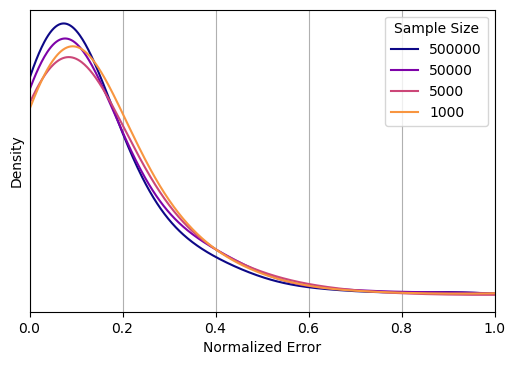

In [17]:
colors = colormap(np.linspace(0, 0.75, len(set(sample_size_test))))

plt.figure(dpi=100)
for c,i in enumerate(sorted(list(set(sample_size_test)), reverse=True)):
    sample = errors[sample_size_test==i]
    kde = scipy.stats.gaussian_kde(sample)
    x = np.linspace(0, 2, 1000)
    density = kde(x)
    plt.plot(x, density, color=colors[c], alpha=1, label=int(i))
plt.legend(title='Sample Size');
plt.gcf().set_facecolor('white')
plt.grid();
plt.xlabel('Normalized Error')
plt.ylabel('Density')
plt.gca().set_yticks([])
plt.xlim([0, 1]);
